In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import models
import payoffs
import selection_functions

In [2]:
%matplotlib inline
plt.style.use("ggplot")

# Basic simulation

In [738]:
integrate.solve_ivp?

In [5]:
# random initial condition
prng = np.random.RandomState(42)
number_of_genotypes = 4
y0, = prng.dirichlet(np.ones(number_of_genotypes), 1)

# define the selection functions
d0, d2 = 1.5, 1
UGA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d0)
UgA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d2)

# define the payoffs
payoff_kernel = payoffs.prisoners_dilemma_payoffs(prng)

f = lambda t, y: models.generalized_sexual_selection(y, UGA, UgA, payoff_kernel)
result = integrate.solve_ivp(f, t_span=(0, 10), y0=y0, rtol=1e-9, atol=1e-12, dense_output=True, vectorized=True)

In [6]:
result

  message: 'The solver successfully reached the interval end.'
     nfev: 722
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x1154053c8>
   status: 0
  success: True
        t: array([  0.00000000e+00,   7.35384685e-03,   8.08923153e-02,
         2.12012404e-01,   3.43132493e-01,   4.74252581e-01,
         5.88817737e-01,   7.03580611e-01,   8.18343485e-01,
         9.33106359e-01,   1.03638170e+00,   1.13980130e+00,
         1.24322091e+00,   1.34664051e+00,   1.45006012e+00,
         1.55347972e+00,   1.64491327e+00,   1.73648766e+00,
         1.82806205e+00,   1.91963644e+00,   2.01121083e+00,
         2.10278522e+00,   2.19435961e+00,   2.27643847e+00,
         2.35861484e+00,   2.44079120e+00,   2.52296757e+00,
         2.60514393e+00,   2.68732029e+00,   2.76949666e+00,
         2.85167302e+00,   2.93384938e+00,   3.01602575e+00,
         3.09820211e+00,   3.17158029e+00,   3.24502964e+00,
         3.31847898e+00,   3.39192833e+00,   3.46

In [7]:
# sanity check that the simulated trajectory satisfies adding up constraint
assert np.allclose(result.y.sum(axis=0), np.ones(result.t.size))

# Interactive simulation

In [8]:
def plot_generalized_sexual_selection(x0=0.25, x1=0.25, x2=0.25, selection_function="kirkpatrick",
                                      d0=1, d2=1, T=10, R=6, P=4, S=0, mutation_rate=0.0, max_time=10):

    fig, ax = plt.subplots(1,1, figsize=(10,8))

    # prepare the axes
    ax.set_ylim((0, 1))
    ax.set_xlabel(r"Time, $t$", fontsize=15)
    ax.set_ylabel(r"Female genotype shares, $x_i$", fontsize=15)
    
    # create the initial condition
    x3 = 1 - (x0 + x1 + x2)
    y0=np.array([x0,x1,x2,x3])
    assert np.allclose(y0.sum(), 1)
    
    # create the payoff kernel
    assert T > R and R > P and R > S, "Payoffs must satisfy either Prisoner's Dilemma or Stag Hunt constraints!"
    payoff_kernel = np.array([[R, S],
                              [T, P]])
    
    # create the selection functions
    if selection_function == "kirkpatrick":
        UGA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d0)
        UgA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d2)
    elif selection_function == "seger":
        UGA = lambda x_A: seger_selection(x_A, d0)
        UgA = lambda x_A: seger_selection(x_A, d2)
    else:
      raise ValueError("selection_function must be one of \"kirkpatrick\" or \"seger\".")
    
    # simulate the model starting from a random initial condition
    f = lambda t, y: models.generalized_sexual_selection(y, UGA, UgA, payoff_kernel, mutation_rate)
    result = integrate.solve_ivp(f, t_span=(0, max_time), y0=y0, rtol=1e-9, atol=1e-12,
                                 dense_output=True, vectorized=True)
    
    ax.plot(result.t, result.y[0], label="GA")
    ax.plot(result.t, result.y[1], label="Ga")
    ax.plot(result.t, result.y[2], label="gA")
    ax.plot(result.t, result.y[3], label="ga")
    ax.legend()
    plt.show()

    return result

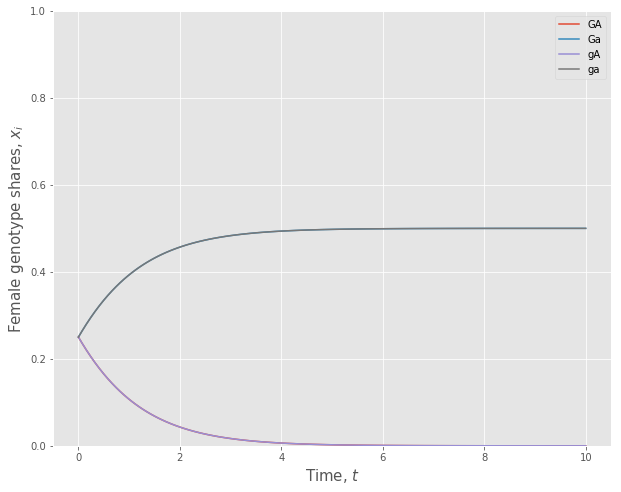

In [9]:
result = plot_generalized_sexual_selection(selection_function="kirkpatrick", T=50)

In [10]:
# sliders used to control the initial condition
x0_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_0$")
x1_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_1$")
x2_slider = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01, description=r"$x_2$")

# sliders used to control the Prisoner's Dilemma Payoffs
T_slider = widgets.FloatSlider(value=10, min=0, max=100, step=0.1, description=r"$T$")
R_slider = widgets.FloatSlider(value=8, min=0, max=100, step=0.1, description=r"$R$")
P_slider = widgets.FloatSlider(value=6, min=0, max=100, step=0.1, description=r"$P$")
S_slider = widgets.FloatSlider(value=4, min=0, max=100, step=0.1, description=r"$S$")

# slider used to control which selection function is being used
U_slider = widgets.Dropdown(options=["kirkpatrick", "seger"], index=0, description=r"$U$")

# slider that controls the parameters of the selection function
d0_slider = widgets.FloatSlider(value=1, min=0.0, max=10, step=0.05, description=r"$d_0$")
d2_slider = widgets.FloatSlider(value=1, min=0.0, max=10, step=0.05, description=r"$d_2$")

# slider used to control the mutation rate
e_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=1e-3, description=r"$\epsilon$", readout_format=".3f")

# slider that controls max simulation time
max_time_slider = widgets.IntSlider(value=25, min=1, max=500, description=r"$\max t$")

w = widgets.interactive(plot_generalized_sexual_selection, x0=x0_slider, x1=x1_slider, x2=x2_slider,
                        selection_function=U_slider, d0=d0_slider, d2=d2_slider, 
                        T=T_slider, R=R_slider, P=P_slider, S=S_slider, 
                        mutation_rate=e_slider, max_time=max_time_slider)
display(w)

A Jupyter Widget

In [11]:
# sanity check on the resulting trajectory
assert np.allclose(result.y.sum(axis=0), np.ones(result.t.size))